In [4]:
import numpy as np
#from LogGabor import LogGaborFit
import matplotlib.pyplot as plt
from torchvision.utils import make_grid, save_image
import torch
from SDPC_PCB.Coding import ML_Lasso,ML_FISTA
import pickle
from SDPC_PCB.DataTools import LCN, whitening, z_score, mask, to_cuda, norm
import torch.nn.functional as f

from  SDPC_PCB.DataTools import DataBase, ssim
from SDPC_PCB.Network import LayerPC, Network
from SDPC_PCB.Coding import ML_Lasso,ML_FISTA
from SDPC_PCB.DataTools import DataBase
from SDPC_PCB.Monitor import Monitor
from SDPC_PCB.Optimizers import mySGD, myAdam
import torch.nn.functional as f
import torch.nn as nn
import torch
import time
import tensorboardX
from SDPC_PCB.DataTools import LCN, whitening, z_score, mask, to_cuda, norm
from torchvision.utils import make_grid
import numpy as np
from tensorboardX import SummaryWriter
import pickle
from torchvision.transforms import ToTensor, Compose
from torchvision import transforms
from torch.utils.data import DataLoader
import torch.optim as optim
from SDPC_PCB.Monitor import Monitor
import math

import matplotlib.pyplot as plt

from scipy.stats import wilcoxon
from decimal import Decimal

In [5]:
cmap1=plt.get_cmap('tab20c')
cmap2=plt.get_cmap('tab20b')
color_fb=['slategrey',cmap1(3),cmap1(2),cmap1(1),cmap1(0)]

In [3]:
grid_param = grid_param = {'padding':1, 'normalize':True, 
                            'pad_value':1, 
                            'nrow':8}

save = False

In [6]:
data_path ='../DataSet/CF_DB_testing/'

LCN_params = {'kernel_size':11,
'sigma':0.5,
'rgb':True}

mask_params={'n': 10}# default is 10

whitening_params={'f_0':0.5,
'n':2}

Data_load_param = {'batch_size': 40,
'do_LCN': True,
'LCN_params': LCN_params,
'do_mask': True,
'mask_params': mask_params,
'do_whitening': True,
'whitening_params': whitening_params,
'do_z_score': True,
'return_idx': False}

Facedata = DataBase('from_ImageFolder', data_path, img_size=(100,124), reshaped_size=(120,171),**Data_load_param, shuffle=False)

In [7]:
#def Entropy(histo_of_proba):
#    return -(histo_of_proba*torch.log2(histo_of_proba)).sum()
#def KL_uniform(histo_of_proba):
#    equiproba = 1/histo_of_proba.size(0)
#    return (histo_of_proba*torch.log2(histo_of_proba/equiproba)).sum()
#def gamma_pdf(x,lbda_param):
#    return lbda_param*np.exp(-lbda_param*x)

#def halfnormal_pdf(x,sig):
#    return (np.sqrt(2)/ (np.sqrt(np.pi) * sig))*np.exp(-(x**2)/(2*sig**2))

def show(img):
    npimg = img.numpy()
    ax.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')
    plt.axis('off')
    return plt

def show_ax(img,ax):
    npimg = img.numpy()
    ax.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')
    #plt.axis('off')
    return ax

def reconstruction(Net,gamma):
    reco = [None] * (Net.nb_layers)
    for i in range(Net.nb_layers-1,-1,-1):
        reco[i] = gamma[i]
        for j in range(i, -1, -1):
            reco[i] = Net.layers[j].backward(reco[i])
    return reco

# Inference with different noise level and feedback strength

## Noise Robustness

In [9]:
model_name = 'CFD_[0.3,1.6]_b=1.pkl'
feedback_list = [0,1,2,3,4]
where = 'Savings/CFD/'

std_list = [0,1,2,3,4,5]
all_reco = torch.zeros(len(std_list),len(feedback_list),2,3,120,171)
noisy_input = torch.zeros(len(std_list),3,120,171)
nb_image = 400
all_ssim = torch.zeros(nb_image,len(std_list),len(feedback_list),2)
ssim_baseline = torch.zeros(nb_image,len(std_list))
#if save_simulation == True:
for k_FB in feedback_list:
#for idx_model, model_name in enumerate(model_name_list) : 
    model_type = model_name[0:8]
    name = model_name
    print(name)

    path = where + name
    with open(path, 'rb') as file:
        out = pickle.load(file)
    Net = out['Net']

    for i in range(Net.nb_layers):
        Net.layers[i].b = k_FB
    Loss = ML_Lasso(Net, [0.3,1.6])
    Pursuit = ML_FISTA(Net, Loss, max_iter=1000, th=5e-3, mode='eigen', accell=True)

    for noise_idx, std in enumerate(std_list):
        k=0
        for idx_batch, data in enumerate(Facedata.data):
            image_ori = data[0].cuda()
            batch = data[0].cuda() + std*torch.randn(data[0].size()).cuda()

            gamma, it, Loss_G, delta = Pursuit.coding(batch)
            rec = reconstruction(Net,gamma)

            normalizer = image_ori.view(data[0].size(0),-1).max(dim=1)[0]
            normalized_image = image_ori.div(normalizer.unsqueeze(-1).unsqueeze(-1).unsqueeze(-1))

            if k_FB == 0:
                normalizer_noisy = batch.view(data[0].size(0),-1).max(dim=1)[0]
                normalized_noisy = batch.div(normalizer_noisy.unsqueeze(-1).unsqueeze(-1).unsqueeze(-1))

                ssim_baseline[k:k+batch.size(0),noise_idx] += ssim(normalized_image,normalized_noisy)
            for i in range(Net.nb_layers):
                normalizer = rec[i].view(data[0].size(0),-1).max(dim=1)[0]
                normalized_reco = rec[i].div(normalizer.unsqueeze(-1).unsqueeze(-1).unsqueeze(-1))
                all_ssim[k:k+batch.size(0),noise_idx,k_FB,i] += ssim(normalized_image,normalized_reco)                
                all_reco[noise_idx,k_FB,i, :,:,:]=normalized_reco[9,:,:,:]
            noisy_input[noise_idx, :,:,:]=batch[9,:,:,:]


            print('total Image',k+batch.size(0)) 
            k+=batch.size(0)
            if k >= nb_image:
                break

Exp = {'model_name': feedback_list,
       'std_list':std_list,
        'ssim' : all_ssim,
        'reco':all_reco,
        'noisy_input':noisy_input,
        'ssim_baseline':ssim_baseline}


CFD_[0.3,1.6]_b=1.pkl
total Image 40
total Image 80
total Image 120
total Image 160
total Image 200
total Image 240
total Image 280
total Image 320
total Image 360
total Image 400
total Image 40
total Image 80
total Image 120
total Image 160
total Image 200
total Image 240
total Image 280
total Image 320
total Image 360
total Image 400
total Image 40
total Image 80
total Image 120
total Image 160
total Image 200
total Image 240
total Image 280
total Image 320
total Image 360
total Image 400
total Image 40
total Image 80
total Image 120
total Image 160
total Image 200
total Image 240
total Image 280
total Image 320
total Image 360
total Image 400
total Image 40
total Image 80
total Image 120
total Image 160
total Image 200
total Image 240
total Image 280
total Image 320
total Image 360
total Image 400
total Image 40
total Image 80
total Image 120
total Image 160
total Image 200
total Image 240
total Image 280
total Image 320
total Image 360
total Image 400
CFD_[0.3,1.6]_b=1.pkl
total Im

"\n    with open(path_saving, 'wb') as file:\n        pickle.dump(Exp, file, pickle.HIGHEST_PROTOCOL)\nelse : \n    with open(path_saving, 'rb') as file:\n        Exp = pickle.load(file)\n"

## Fig11b and c

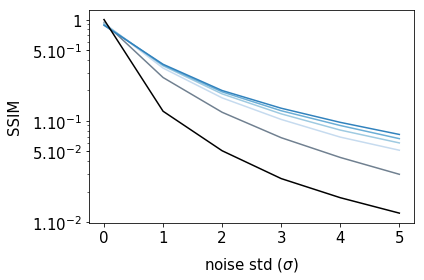

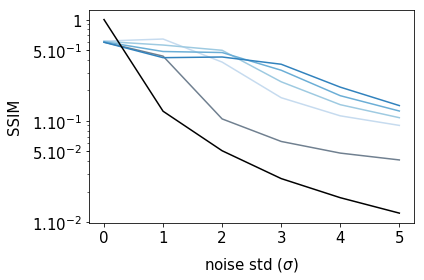

In [11]:
save_fig = False
mean_ssim = Exp['ssim'].median(dim=0)[0]
mean_ssim_baseline = Exp['ssim_baseline'].median(dim=0)[0]
color=['slategrey',cmap1(3),cmap1(2),cmap1(1),cmap1(0)]
std_list = Exp['std_list']
b_list = np.arange(len(Exp['model_name']))

fig = plt.figure()
for idx_b, b in enumerate(b_list):
    plt.plot(std_list ,mean_ssim[:,idx_b,0].numpy(),label='b={0}'.format(b),color=color[idx_b])

plt.plot(std_list,mean_ssim_baseline.numpy(), label='baseline',color='black')

plt.yscale("log")
plt.ylabel('SSIM', fontsize=15, labelpad=10)

plt.xlabel('noise std ' + r'$(\sigma)$', fontsize=15, labelpad=10)
plt.xticks(std_list, fontsize=15)
plt.yticks([0.01,0.05,0.1,0.5,1], \
           [r'$1.10^{-2}$',r'$5.10^{-2}$',r'$1.10^{-1}$',r'$5.10^{-1}$',r'$1$'], fontsize=15)

if save_fig == True:
    plt.tight_layout()
    plt.savefig('Savings/Fig/Fig11/Fig11b.png',\
                bbox_inches = 'tight', pad_inches = 0, dpi= 400)
plt.show()

fig = plt.figure()
for idx_b, b in enumerate(b_list):
    plt.plot(std_list, mean_ssim[:,idx_b,1].numpy(),label=r'$k_{FB}$'+ '={0}'.format(b), color=color[idx_b])
    
plt.plot(std_list,mean_ssim_baseline.numpy(), label='baseline',color='black')

plt.ylabel('SSIM', fontsize=15, labelpad=10)
plt.yscale("log")
plt.xlabel('noise std ' + r'$(\sigma)$', fontsize=15, labelpad=10)
plt.xticks(std_list, fontsize=15)
plt.yticks([0.01,0.05,0.1,0.5,1], \
           [r'$1.10^{-2}$',r'$5.10^{-2}$',r'$1.10^{-1}$',r'$5.10^{-1}$',r'$1$'], fontsize=15)

#plt.legend(loc='lower center',bbox_to_anchor=(0.5, -0.5),ncol=6,fontsize=15)
if save_fig == True:
    plt.tight_layout()
    plt.savefig('Savings/Fig/Fig11/Fig11c.png',\
                bbox_inches = 'tight', pad_inches = 0, dpi= 400)

plt.show()    



## Fig S6a

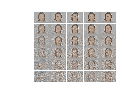

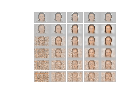

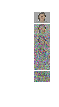

In [12]:
save_fig=False

model_name_list = Exp['model_name']
std_list = Exp['std_list']
all_reco = Exp['reco']
noisy_input = Exp['noisy_input']

total_patch_nb = len(std_list)*len(model_name_list)
to_plot_reorganized = torch.zeros(total_patch_nb,3,120,171).cuda()




grid_param = grid_param = {'padding':8, 'normalize':True, 
                            'pad_value':1, 
                            'nrow':len(model_name_list)}


### Plotting Layer 1 reconstruction
for i in std_list:
    to_plot_reorganized[i*len(model_name_list):(i+1)*len(model_name_list),:,:,:] = all_reco[i,:,0,:,:,:]
    
img2 = make_grid(to_plot_reorganized,**grid_param)

fig = plt.figure()
height = img2.size(-2)
width = img2.size(-1)

fig.set_size_inches(width/height, 1, forward=False)
ax = plt.Axes(fig, [0., 0., 1., 1.])
ax.set_axis_off()
fig.add_axes(ax)
plot_L2 = show_ax(img2.cpu(),ax)
if save_fig :
    plt.tight_layout()
    plt.savefig('Savings/Fig/FigS6/FigS6a_layer1.png', dpi= height)
plt.show()


    
### Plotting Layer 2 reconstruction    
to_plot_reorganized = torch.zeros(total_patch_nb,3,120,171).cuda()
for i in std_list:
    to_plot_reorganized[i*len(model_name_list):(i+1)*len(model_name_list),:,:,:] = all_reco[i,:,1,:,:,:]
    
img2 = make_grid(to_plot_reorganized,**grid_param)

fig = plt.figure()
height = img2.size(-2)
width = img2.size(-1)

fig.set_size_inches(width/height, 1, forward=False)
ax = plt.Axes(fig, [0., 0., 1., 1.])
ax.set_axis_off()
fig.add_axes(ax)
plot_L2 = show_ax(img2.cpu(),ax)
if save_fig :
    plt.tight_layout()
    plt.savefig('Savings/Fig/FigS6/FigS6a_layer2.png', dpi= height)
plt.show()

    
### Plotting the input
grid_param = grid_param = {'padding':8, 'normalize':True, 
                            'pad_value':1, 
                            'nrow':1, 'scale_each':True}

img2 = make_grid(noisy_input,**grid_param)
fig = plt.figure()
height = img2.size(-2)
width = img2.size(-1)

fig.set_size_inches(width/height, 1, forward=False)
ax = plt.Axes(fig, [0., 0., 1., 1.])
ax.set_axis_off()
fig.add_axes(ax)
plot_L2 = show_ax(img2.cpu(),ax)
if save_fig :
    plt.tight_layout()
    plt.savefig('Savings/Fig/FigS6/FigS6a_input.png', dpi= height)
plt.show()

## Fig S6b and c

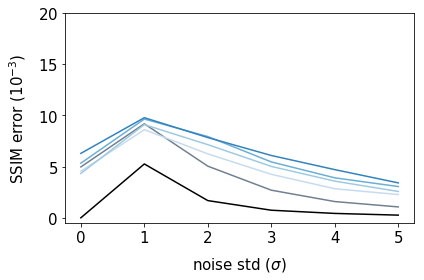

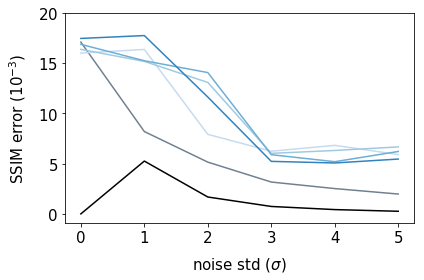

In [13]:
save_fig = False
color=['slategrey',cmap1(3),cmap1(2),cmap1(1),cmap1(0)]
std_list = Exp['std_list']


std_ssim = (Exp['ssim'] - Exp['ssim'].median(dim=0)[0].unsqueeze(0)).abs()
std_ssim = std_ssim.mean(dim=0)


std_ssim_baseline = (Exp['ssim_baseline'] - Exp['ssim_baseline'].median(dim=0)[0].unsqueeze(0)).abs()
std_ssim_baseline = std_ssim_baseline.mean(dim=0)

fig = plt.figure()
for idx_b, b in enumerate(b_list):
    std_0 = std_ssim[:,idx_b,0]
    plt.plot(std_list ,std_0.numpy(),label='b={0}'.format(b),color=color[idx_b])
plt.plot(std_list,std_ssim_baseline.numpy(), color='black')

plt.ylabel('SSIM error ' + r'($10^{-3}$)' , fontsize=15, labelpad=10)

plt.xlabel('noise std ' + r'$(\sigma)$', fontsize=15, labelpad=10)
plt.xticks(std_list, fontsize=15)
plt.yticks([0,0.005,0.01,0.015,0.02], \
           [r'$0$',r'$5$',r'$10$',r'$15$',r'$20$'], fontsize=15)

if save_fig == True:
    plt.tight_layout()
    plt.savefig('Savings/Fig/FigS6/FigS6d.png',\
                bbox_inches = 'tight', pad_inches = 0.02, dpi= 400)

plt.show()

fig = plt.figure()
for idx_b, b in enumerate(b_list):
    std_0 = std_ssim[:,idx_b,1]
    plt.plot(std_list ,std_0.numpy(),label='b={0}'.format(b),color=color[idx_b])
plt.plot(std_list,std_ssim_baseline.numpy(), color='black')

plt.ylabel('SSIM error ' + r'($10^{-3}$)' , fontsize=15, labelpad=10)

plt.xlabel('noise std ' + r'$(\sigma)$', fontsize=15, labelpad=10)
plt.xticks(std_list, fontsize=15)
plt.yticks([0,0.005,0.01,0.015,0.02], \
           [r'$0$',r'$5$',r'$10$',r'$15$',r'$20$'], fontsize=15)

if save_fig == True:
    plt.tight_layout()
    plt.savefig('Savings/Fig/FigS6/FigS6e.png',\
                bbox_inches = 'tight', pad_inches = 0.02, dpi= 400)

plt.show()



## Fig13

In [14]:
data_path ='../DataSet/CF_DB_testing/'

LCN_params = {'kernel_size':11,
'sigma':0.5,
'rgb':True}

mask_params={'n': 10}# default is 10

whitening_params={'f_0':0.5,
'n':2}

Data_load_param = {'batch_size': 40,
'do_LCN': True,
'LCN_params': LCN_params,
'do_mask': True,
'mask_params': mask_params,
'do_whitening': True,
'whitening_params': whitening_params,
'do_z_score': True,
'return_idx': False}

Facedata = DataBase('from_ImageFolder', data_path, img_size=(100,124), reshaped_size=(120,171),**Data_load_param, shuffle=False)

### Inference for different value of lbda1 and different noise level

In [15]:
model_name = 'CFD_[0.3,1.6]_b=1.pkl'
where = 'Savings/CFD/'

feedback_list = [4]

lbda1_list = [0.0,1.5,3.0]
std_list = [0,1,2,3,4,5]
all_reco = torch.zeros(len(std_list),len(feedback_list),2,3,120,171)
noisy_input = torch.zeros(len(std_list),3,120,171)
nb_image = 40
nb_batch = 10
all_ssim = torch.zeros(nb_batch,len(std_list),len(lbda1_list),2)

            
ssim_baseline = torch.zeros(nb_batch,len(std_list))

for idx_k, k_FB in enumerate(feedback_list):
    for lbda1_idx, lbda1 in enumerate(lbda1_list) : 
        model_type = model_name[0:8]
        name = model_name
        print(name)

        path = where + name
        with open(path, 'rb') as file:
            out = pickle.load(file)
        Net = out['Net']

        for i in range(Net.nb_layers):
            Net.layers[i].b = k_FB
        Loss = ML_Lasso(Net, [lbda1,1.6])
        print('Exp [{0},1.6]'.format(lbda1))

        Pursuit = ML_FISTA(Net, Loss, max_iter=1000, th=5e-3, mode='eigen', accell=True)
        for noise_idx, std in enumerate(std_list):
            k=0
            for idx_batch, data in enumerate(Facedata.data):

                image_ori = data[0].cuda()
                batch = data[0].cuda() + std*torch.randn(data[0].size()).cuda()

                gamma, it, Loss_G, delta = Pursuit.coding(batch)
                print(it)
                rec = reconstruction(Net,gamma)

                normalizer = image_ori.view(data[0].size(0),-1).max(dim=1)[0]
                normalized_image = image_ori.div(normalizer.unsqueeze(-1).unsqueeze(-1).unsqueeze(-1))


                normalizer_noisy = batch.view(data[0].size(0),-1).max(dim=1)[0]
                normalized_noisy = batch.div(normalizer_noisy.unsqueeze(-1).unsqueeze(-1).unsqueeze(-1))

                ssim_baseline[idx_batch,noise_idx] = ssim(normalized_image,normalized_noisy)

                for i in range(Net.nb_layers):
                    normalizer = rec[i].view(data[0].size(0),-1).max(dim=1)[0]
                    normalized_reco = rec[i].div(normalizer.unsqueeze(-1).unsqueeze(-1).unsqueeze(-1))
                    all_ssim[idx_batch,noise_idx,lbda1_idx,i] = ssim(normalized_image,normalized_reco)                
                    all_reco[noise_idx,idx_k,i, :,:,:]=normalized_reco[9,:,:,:]
                noisy_input[noise_idx, :,:,:]=batch[9,:,:,:]

                k+=batch.size(0)
                if idx_batch >= nb_batch-1:
                    break

Exp = {'model_name': feedback_list,
       'std_list':std_list,
        'ssim' : all_ssim,
        'reco':all_reco,
        'noisy_input':noisy_input,
        'ssim_baseline':ssim_baseline}


CFD_[0.3,1.6]_b=1.pkl
Exp [0.0,1.6]
52
50
51
52
51
53
50
48
49
51
14
14
14
14
14
14
15
15
14
14
17
17
16
17
17
17
17
17
17
17
17
17
17
17
17
17
17
17
17
17
17
17
17
17
17
17
17
17
17
17
17
17
17
17
17
17
17
17
17
17
CFD_[0.3,1.6]_b=1.pkl
Exp [1.5,1.6]
43
42
42
42
41
44
42
40
41
43
10
11
11
11
11
11
11
11
11
11
15
15
15
15
15
15
15
15
15
15
16
16
16
16
16
16
16
16
16
16
17
17
17
17
17
17
17
17
17
17
17
17
17
17
17
17
17
17
17
17
CFD_[0.3,1.6]_b=1.pkl
Exp [3.0,1.6]
40
40
39
40
39
41
39
38
38
40
11
11
11
11
11
11
11
11
11
11
14
15
15
15
14
14
15
15
15
14
16
16
16
16
16
16
16
16
16
16
17
17
17
17
17
17
17
17
17
17
17
17
17
17
17
17
17
17
17
17


tensor([1.0000, 0.1257, 0.0502, 0.0270, 0.0172, 0.0122])
torch.Size([6, 3])


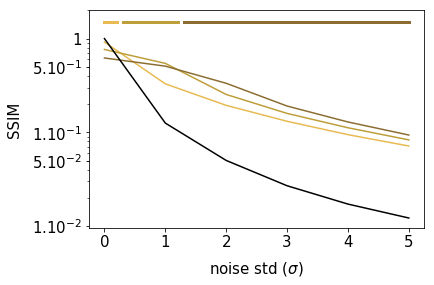

torch.Size([6, 3])


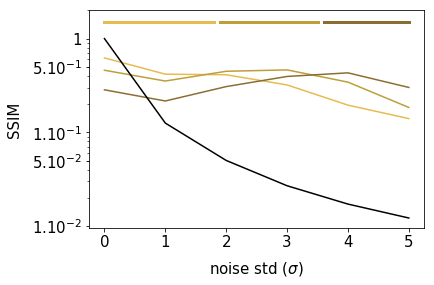

In [18]:
save_fig = False
all_ssim = Exp['ssim']
ssim_bl = Exp['ssim_baseline']
mean_ssim_baseline = ssim_bl.mean(dim=0)
mean_ssim = all_ssim.mean(dim=0)[:,:,0]
print(mean_ssim_baseline)
cmap2=plt.get_cmap('tab20b')
#color_lbda=[cmap2(6),cmap2(5),cmap2(4)]
color_lbda=[cmap2(10),cmap2(9),cmap2(8)]


print(mean_ssim.size())


fig = plt.figure()
for idx_lbda, lbda1 in enumerate(lbda1_list):
    plt.plot(std_list ,mean_ssim[:,idx_lbda].numpy(),label=r'$\lambda_{1}=$'+'{0}'.format(lbda1),color=color_lbda[idx_lbda])

plt.plot(std_list,mean_ssim_baseline.numpy(), label='baseline',color='black')


plt.plot([0.0,0.2],[1.5,1.5], linewidth=3, color=color_lbda[0])
plt.plot([0.3,1.2],[1.5,1.5], linewidth=3, color=color_lbda[1])
plt.plot([1.3,5],[1.5,1.5], linewidth=3, color=color_lbda[2])



plt.yscale("log")
plt.ylabel('SSIM', fontsize=15, labelpad=10)
plt.ylim((0,2))
plt.xlabel('noise std ' + r'$(\sigma)$', fontsize=15, labelpad=10)
plt.xticks(std_list, fontsize=15)
plt.yticks([0.01,0.05,0.1,0.5,1], \
           [r'$1.10^{-2}$',r'$5.10^{-2}$',r'$1.10^{-1}$',r'$5.10^{-1}$',r'$1$'], fontsize=15)

if save_fig == True:
    plt.tight_layout()
    plt.savefig('Savings/Fig/Fig12/Fig12a.png',\
                bbox_inches = 'tight', pad_inches = 0, dpi= 400)
#plt.legend(loc='lower center',bbox_to_anchor=(0.5, -0.5),ncol=6,fontsize=15)
plt.show()

all_ssim = Exp['ssim']
mean_ssim = all_ssim.mean(dim=0)[:,:,1]
print(mean_ssim.size())


fig = plt.figure()
for idx_lbda, lbda1 in enumerate(lbda1_list):
    plt.plot(std_list ,mean_ssim[:,idx_lbda].numpy(),label=r'$\lambda_{1}=$'+'{0}'.format(lbda1),color=color_lbda[idx_lbda])

plt.plot(std_list,mean_ssim_baseline.numpy(), label='baseline',color='black')

plt.plot([0.0,1.8],[1.5,1.5], linewidth=3, color=color_lbda[0])
plt.plot([1.9,3.5],[1.5,1.5], linewidth=3, color=color_lbda[1])
plt.plot([3.6,5],[1.5,1.5], linewidth=3, color=color_lbda[2])
          
plt.yscale("log")
plt.ylabel('SSIM', fontsize=15, labelpad=10)
plt.ylim((0,2))
plt.xlabel('noise std ' + r'$(\sigma)$', fontsize=15, labelpad=10)
plt.xticks(std_list, fontsize=15)
plt.yticks([0.01,0.05,0.1,0.5,1], \
           [r'$1.10^{-2}$',r'$5.10^{-2}$',r'$1.10^{-1}$',r'$5.10^{-1}$',r'$1$'], fontsize=15)
if save_fig == True:
    plt.tight_layout()
    plt.savefig('Savings/Fig/Fig13/Fig13b.png',\
                bbox_inches = 'tight', pad_inches = 0, dpi= 400)

#plt.legend(loc='lower center',bbox_to_anchor=(0.5, -0.5),ncol=6,fontsize=15)
plt.show()